In [18]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import re
import requests
from transformers import pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Dataset

In [20]:
df = pd.read_csv(r'C:\Users\arceb\PycharmProjects\Projet_DSSS_2023\data_cleaned/initial_corpus.csv')
df

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
1,Le Monde,Récit Les trois semaines qui ont chamboulé l...,2020-03-27,"Éric Albert, Cécile Boutelet, Jérôme Gautheret...","Londres, Berlin, Rome et Bruxelles corresponda...","- Jeudi 26 mars, les Vingt-Sept devaient se r...","pandémie touche tout le monde, indifféremment ...",Monde
2,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro
3,Le Monde (site web),Coronavirus : les trois semaines qui ont chamb...,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet...","Jeudi 26 mars, les Vingt-Sept doivent se réuni...",n visioconférence pour la troisième fois en mo...,"e la tenue de ses comptes publics, n’est pas s...",Monde
4,Le Monde (site web),Marc Lazar : « Plus l’Italie fait nation face ...,2020-03-25,Marc Lazar,Tribune. L’Italie est le pays qui enregistre à...,date du 25 mars le plus grand nombre de morts...,t de la School of Government de la Luiss (Libr...,Monde
...,...,...,...,...,...,...,...,...
8913,Les Echos,Crise migratoire aux Canaries : l'Europe doit...,2020-05-27,NaN,"La déception a été à la hauteur de l'espoir, i...","nse, il y a dix ans. Le 17 december2010, le su...",e n'ait été qu'une illustration de cette ligne...,Echos
8914,La Croix,Migrants en mer Egée : «Ça a été les deux heur...,2020-04-15,NaN,"Les faits En 2015, des «?zones de transit?» av...",nt été mises en place par le pays dans les vil...,programme lancé en 2015 de répartition par Éta...,Croix
8915,Le Figaro,"Migrants: Dakhla, point de départ du grand cou...",2020-04-14,NaN,Bruxelles espère arriver à des « résultats imp...,ants » en 2021 sur la réforme de l'asile prése...,oit d'asile depuis le pays européen où ils son...,Figaro
8916,Le Figaro,Pacte migratoire?: les pays du sud sauveront-i...,2020-04-12,NaN,C'EST L'UNE des rares bonnes nouvelles de l'an...,"2020 : la pandémie, grâce au plan de relance ...",une victoire à la Pyrrhus... Et dans tous les ...,Figaro


### CAMEMBERT

In [21]:
from transformers import pipeline

# Set up the inference pipeline using a model from the 🤗 Hub
sentiment_analysis = pipeline(model="Peed911/french_sentiment_analysis")

In [66]:
# Function to find the nearest end-of-sentence punctuation within a text chunk
def find_split_point(chunk):
    # Search for end-of-sentence punctuation within the chunk
    match = re.search(r'[.!?]', chunk)
    if match:
        # Return the index of the punctuation plus one to include it in the first part
        return match.end()
    else:
        # If no punctuation found, return the end of the chunk
        return len(chunk)

# Function to split text into four parts without splitting sentences
def split_and_duplicate(row):
    text = row['Texte']
    text_length = len(text)
    part_length = text_length // 4  # Calculate the approximate length of each part

    # Split the text into four parts
    part1_end = find_split_point(text[:part_length])
    part2_end = find_split_point(text[part_length:2*part_length])
    part3_end = find_split_point(text[2*part_length:3*part_length])
    part4_end = find_split_point(text[3*part_length:])

    # Extract parts based on the found split points
    part1 = text[:part1_end]
    part2 = text[part1_end:part2_end]
    part3 = text[part2_end:part3_end]
    part4 = text[part3_end:part4_end]

    # Create four new rows with the split text parts
    row1 = row.copy()
    row1['Texte'] = part1.strip()

    row2 = row.copy()
    row2['Texte'] = part2.strip()

    row3 = row.copy()
    row3['Texte'] = part3.strip()

    row4 = row.copy()
    row4['Texte'] = part4.strip()

    return pd.DataFrame([row1, row2, row3, row4])

# Apply the function to each row and concatenate the results
df_split = pd.concat(df.apply(split_and_duplicate, axis=1).tolist(), ignore_index=True)



df_split

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les faits.,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
1,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",Sur les camions militaires,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
2,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle","qui, en colonnes, ont relié Rome à Bergame l","Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
3,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle","a semaine dernière, les sti","Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
4,Le Monde,Récit Les trois semaines qui ont chamboulé l...,2020-03-27,"Éric Albert, Cécile Boutelet, Jérôme Gautheret...","Londres, Berlin, Rome et Bruxelles corresponda...","- Jeudi 26 mars, les Vingt-Sept devaient se r...","pandémie touche tout le monde, indifféremment ...",Monde
...,...,...,...,...,...,...,...,...
35667,Le Figaro,Pacte migratoire?: les pays du sud sauveront-i...,2020-04-12,NaN,,"2020 : la pandémie, grâce au plan de relance ...",une victoire à la Pyrrhus... Et dans tous les ...,Figaro
35668,Le Figaro,"«Place de la République, les migrants n’étaien...",2020-04-05,NaN,"16/20 « Raised By Wolves » , dix épisodes d...","0 minutes, lundi 7 decembersur warner tv, à 20...","r, si vous ne vous endormez pas devant cette b...",Figaro
35669,Le Figaro,"«Place de la République, les migrants n’étaien...",2020-04-05,NaN,,"0 minutes, lundi 7 decembersur warner tv, à 20...","r, si vous ne vous endormez pas devant cette b...",Figaro
35670,Le Figaro,"«Place de la République, les migrants n’étaien...",2020-04-05,NaN,20 H 55 Une exoplanète lointaine et désolée ...,"0 minutes, lundi 7 decembersur warner tv, à 20...","r, si vous ne vous endormez pas devant cette b...",Figaro


In [64]:
lendf_split['Texte'][14567]

0

In [38]:
# Creating an empty list to store the results
articles_sentiment = []

# Iterating over each row in the DataFrame
for index, row in df_split.iterrows():
    try:
        content = row['Texte']
        sentiment = sentiment_analysis(content)
        articles_sentiment.append({'article': content, 'sentiment': sentiment})
    except Exception as e:
        print(f"Error processing article at index {index}: {e}")


Error processing article at index 14567: The expanded size of the tensor (566) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 566].  Tensor sizes: [1, 514]


In [39]:
# Creating a new DataFrame from the results
sentiment_df = pd.DataFrame(articles_sentiment)

In [40]:
sentiment_df

,article,sentiment
0,LES SYMBOLES comptent parfois plus que les faits.,"[{'label': 'Negative', 'score': 0.654528439044..."
1,Sur les camions militaires,"[{'label': 'Negative', 'score': 0.579163372516..."
2,"qui, en colonnes, ont relié Rome à Bergame l","[{'label': 'Negative', 'score': 0.533666968345..."
3,"a semaine dernière, les sti","[{'label': 'Negative', 'score': 0.668138563632..."
4,"Londres, Berlin, Rome et Bruxelles corresponda...","[{'label': 'Negative', 'score': 0.676758170127..."
...,...,...
35666,,"[{'label': 'Negative', 'score': 0.535348117351..."
35667,"16/20 « Raised By Wolves » , dix épisodes d...","[{'label': 'Negative', 'score': 0.708983063697..."
35668,,"[{'label': 'Negative', 'score': 0.535348117351..."
35669,20 H 55 Une exoplanète lointaine et désolée ...,"[{'label': 'Negative', 'score': 0.902233958244..."


In [41]:
sentiment_df = sentiment_df.rename(columns={'article': 'Titre'})

In [42]:
sentiment_df['sentiment'] [1]

[{'label': 'Negative', 'score': 0.5791633725166321}]

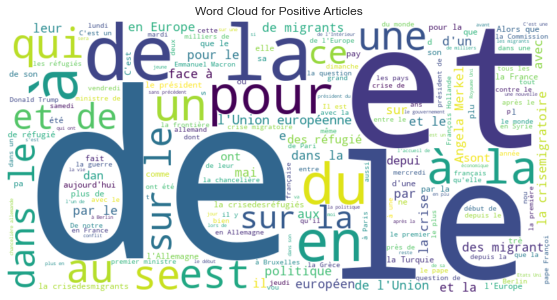

In [44]:
# Function to get sentiment polarity
def get_sentiment_polarity(sentiment):
    label = sentiment[0]['label']
    if label == 'Positive':
        return 1
    elif label == 'Negative':
        return -1
    else:
        return 0

# Apply sentiment analysis to each article
sentiment_df['sentiment_polarity'] = sentiment_df['sentiment'].apply(get_sentiment_polarity)

# Word Cloud
positive_articles = " ".join(sentiment_df[sentiment_df['sentiment_polarity'] == 1]['Titre'])
negative_articles = " ".join(sentiment_df[sentiment_df['sentiment_polarity'] == -1]['Titre'])

# Generate Word Cloud for positive articles
wordcloud_positive = WordCloud(width=800, height=400, background_color ='white').generate(positive_articles)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Articles')
plt.axis('off')
plt.show()


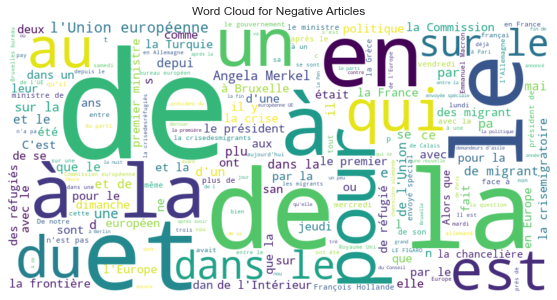

In [45]:
# Generate Word Cloud for negative articles
wordcloud_negative = WordCloud(width=800, height=400, background_color ='white').generate(negative_articles)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Articles')
plt.axis('off')
plt.show()

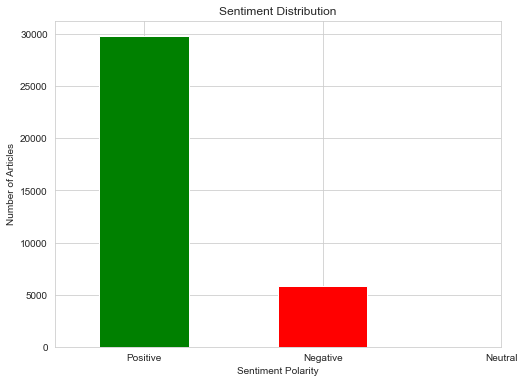

In [46]:
sentiment_counts = sentiment_df['sentiment_polarity'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Articles')
plt.xticks([0, 1, 2], ['Positive', 'Negative', 'Neutral'], rotation=0)
plt.show()

In [50]:
df_split

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les faits.,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
1,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",Sur les camions militaires,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
2,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle","qui, en colonnes, ont relié Rome à Bergame l","Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
3,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle","a semaine dernière, les sti","Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
4,Le Monde,Récit Les trois semaines qui ont chamboulé l...,2020-03-27,"Éric Albert, Cécile Boutelet, Jérôme Gautheret...","Londres, Berlin, Rome et Bruxelles corresponda...","- Jeudi 26 mars, les Vingt-Sept devaient se r...","pandémie touche tout le monde, indifféremment ...",Monde
...,...,...,...,...,...,...,...,...
35667,Le Figaro,Pacte migratoire?: les pays du sud sauveront-i...,2020-04-12,NaN,,"2020 : la pandémie, grâce au plan de relance ...",une victoire à la Pyrrhus... Et dans tous les ...,Figaro
35668,Le Figaro,"«Place de la République, les migrants n’étaien...",2020-04-05,NaN,"16/20 « Raised By Wolves » , dix épisodes d...","0 minutes, lundi 7 decembersur warner tv, à 20...","r, si vous ne vous endormez pas devant cette b...",Figaro
35669,Le Figaro,"«Place de la République, les migrants n’étaien...",2020-04-05,NaN,,"0 minutes, lundi 7 decembersur warner tv, à 20...","r, si vous ne vous endormez pas devant cette b...",Figaro
35670,Le Figaro,"«Place de la République, les migrants n’étaien...",2020-04-05,NaN,20 H 55 Une exoplanète lointaine et désolée ...,"0 minutes, lundi 7 decembersur warner tv, à 20...","r, si vous ne vous endormez pas devant cette b...",Figaro


In [51]:
sentiment_df

,Titre,sentiment,sentiment_polarity
0,LES SYMBOLES comptent parfois plus que les faits.,"[{'label': 'Negative', 'score': 0.654528439044...",-1
1,Sur les camions militaires,"[{'label': 'Negative', 'score': 0.579163372516...",-1
2,"qui, en colonnes, ont relié Rome à Bergame l","[{'label': 'Negative', 'score': 0.533666968345...",-1
3,"a semaine dernière, les sti","[{'label': 'Negative', 'score': 0.668138563632...",-1
4,"Londres, Berlin, Rome et Bruxelles corresponda...","[{'label': 'Negative', 'score': 0.676758170127...",-1
...,...,...,...
35666,,"[{'label': 'Negative', 'score': 0.535348117351...",-1
35667,"16/20 « Raised By Wolves » , dix épisodes d...","[{'label': 'Negative', 'score': 0.708983063697...",-1
35668,,"[{'label': 'Negative', 'score': 0.535348117351...",-1
35669,20 H 55 Une exoplanète lointaine et désolée ...,"[{'label': 'Negative', 'score': 0.902233958244...",-1


In [49]:
def get_sentiment_polarity(sentiment):
    label = sentiment[0]['label']
    if label == 'Positive':
        return 1
    elif label == 'Negative':
        return -1
    else:
        return 0

# Merge sentiment_df with the original DataFrame df on "Titre" column
merged_df = pd.merge(df_split, sentiment_df, on="Texte", how="inner")

# Group by newspaper names and sentiment polarity
grouped_df = merged_df.groupby(['CJournal', 'sentiment_polarity']).size().unstack(fill_value=0)

# Plot
grouped_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Number of Positive and Negative Titles for Each Newspaper')
plt.xlabel('Newspaper')
plt.ylabel('Number of Articles')
plt.legend(['Positive', 'Negative'], loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

KeyError: 'Texte'

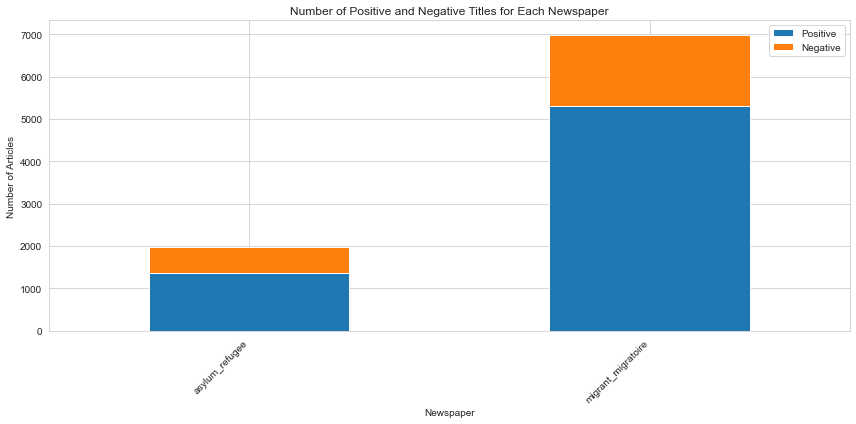

In [65]:
grouped_df_bis = merged_df.groupby(['crisis_term', 'sentiment_polarity']).size().unstack(fill_value=0)

# Plot
grouped_df_bis.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Number of Positive and Negative Titles for Each Newspaper')
plt.xlabel('Newspaper')
plt.ylabel('Number of Articles')
plt.legend(['Positive', 'Negative'], loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [66]:
sentiment_df

,Titre,sentiment,sentiment_polarity
0,L'agenda caché de Moscou en Italie,"[{'label': 'Negative', 'score': 0.6092225909233093}]",-1
1,"Récit Les trois semaines qui ont chamboulé l'orthodoxie économique européenne Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...","[{'label': 'Positive', 'score': 0.5299682021141052}]",1
2,àlargissement de l'Union européenne à l'heure du Coronavirus: «une fuite en avant suicidaire dans le déni»,"[{'label': 'Negative', 'score': 0.718721330165863}]",-1
3,Coronavirus : les trois semaines qui ont chamboulé l'orthodoxie économique européenne,"[{'label': 'Negative', 'score': 0.589116096496582}]",-1
4,"Marc Lazar : « Plus l'Italie fait nation face à l'épidémie, plus elle s'éloigne de l'Union européenne »","[{'label': 'Negative', 'score': 0.6685616970062256}]",-1
...,...,...,...
8021,TUNISIE évacuation des réfugiés,"[{'label': 'Negative', 'score': 0.6489508152008057}]",-1
8022,Libye/UE: 30M d'euros pour les réfugiés,"[{'label': 'Negative', 'score': 0.6869106292724609}]",-1
8023,Courrier,"[{'label': 'Negative', 'score': 0.6549127697944641}]",-1
8024,"Reportage L'étrange aller-retour des Karens opprimés par la junte birmane Après un bref exil en Thaà¯lande, les réfugiés ayant fui les combats ...","[{'label': 'Positive', 'score': 0.5828129649162292}]",1


In [67]:
negatif=sentiment_df[sentiment_df["sentiment_polarity"]==-1]
negatif

,Titre,sentiment,sentiment_polarity
0,L'agenda caché de Moscou en Italie,"[{'label': 'Negative', 'score': 0.6092225909233093}]",-1
2,àlargissement de l'Union européenne à l'heure du Coronavirus: «une fuite en avant suicidaire dans le déni»,"[{'label': 'Negative', 'score': 0.718721330165863}]",-1
3,Coronavirus : les trois semaines qui ont chamboulé l'orthodoxie économique européenne,"[{'label': 'Negative', 'score': 0.589116096496582}]",-1
4,"Marc Lazar : « Plus l'Italie fait nation face à l'épidémie, plus elle s'éloigne de l'Union européenne »","[{'label': 'Negative', 'score': 0.6685616970062256}]",-1
5,Les sept infos non liées au coronavirus que vous avez peut-être manquées cette semaine,"[{'label': 'Negative', 'score': 0.747376024723053}]",-1
...,...,...,...
8017,ANALYSE L'histoire est-elle en train de se répéter au Liban?,"[{'label': 'Negative', 'score': 0.8525354862213135}]",-1
8018,"La réponse a minima des dirigeants européens à la tragédie de Lampedusa La question était à l'ordre du jour du sommet des Vingt-Huit, à Bruxel...","[{'label': 'Negative', 'score': 0.5824561715126038}]",-1
8021,TUNISIE évacuation des réfugiés,"[{'label': 'Negative', 'score': 0.6489508152008057}]",-1
8022,Libye/UE: 30M d'euros pour les réfugiés,"[{'label': 'Negative', 'score': 0.6869106292724609}]",-1


In [124]:
pd.set_option('display.max_colwidth', 150)
print(negatif['Titre'].head(50))

0                                                                                                                        L'agenda caché de Moscou en Italie
2                                              àlargissement de l'Union européenne à  l'heure du Coronavirus: «une fuite en avant suicidaire dans le déni»
3                                                                     Coronavirus : les trois semaines qui ont chamboulé l'orthodoxie économique européenne
4                                                  Marc Lazar : « Plus l'Italie fait nation face à  l'épidémie, plus elle s'éloigne de l'Union européenne »
5                                                                    Les sept infos non liées au coronavirus que vous avez peut-être manquées cette semaine
6                                                                                       Géopolitique | chronique   Nous sommes tous des migrants contrariés
8                                                               

## Text Blob


https://github.com/Txolotl/Group4-Maya-Khaled-Diego-Sentiment-Analysis-with-CamemBERT-model/blob/main/camemBERT_Sentiment_Analysis.ipynb

#### Polarity

In [11]:
#!pip install textblob_fr

   ---------------------------------------- 561.2/561.2 kB 5.9 MB/s eta 0:00:00


In [68]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import re
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
import string
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
import plotly.express as px
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange
import json
import time
import torch
import datetime
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

In [69]:
AComment=[]
for comment in df['Texte'].apply(str):
    mots = []
    for word in  re.sub("\W"," ",comment ).split():
        mots.append(word)
    AComment.append(mots)


In [70]:
df['mots'] = AComment

In [71]:
df

,Unnamed: 0,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,crisis_term,mots
0,1,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle","LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les ...","Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les stick","Deux semaines pour se ressaisir et s'unir ou pour se résigner à la dislocation de l'Europe, qui ne se",Figaro,migrant_migratoire,"[LES, SYMBOLES, comptent, parfois, plus, que, les, faits, Sur, les, camions, militaires, qui, en, colonnes, ont, relié, Rome, à, Bergame, la, sema..."
1,2,Le Monde,"Récit Les trois semaines qui ont chamboulé l'orthodoxie économique européenne Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...",2020-03-27,"àric Albert, Cécile Boutelet, Jérôme Gautheret et Virginie Malingre","Londres, Berlin, Rome et Bruxelles correspondants - Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en ...","- Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en moin","pandémie touche tout le monde, indifféremment de la tenue de ses comptes publics, n'est pas si loin.",Monde,migrant_migratoire,"[Londres, Berlin, Rome, et, Bruxelles, correspondants, Jeudi, 26, mars, les, Vingt, Sept, devaient, se, réunir, en, visioconférence, pour, la, tro..."
2,3,Le Figaro (site web),àlargissement de l'Union européenne à l'heure du Coronavirus: «une fuite en avant suicidaire dans le déni»,2020-03-26,"Tandonnet, Maxime","Fin observateur de la vie politique française et contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompr...","contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompris",es yeux et de se préparer au changement d'un monde plutôt que de s'enferrer dans des obsessions qui s,Figaro,migrant_migratoire,"[Fin, observateur, de, la, vie, politique, française, et, contributeur, régulier, du, FigaroVox, Maxime, Tandonnet, a, notamment, publié, André, T..."
3,4,Le Monde (site web),Coronavirus : les trois semaines qui ont chamboulé l'orthodoxie économique européenne,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet et Virginie Malingre","Jeudi 26 mars, les Vingt-Sept doivent se réunir en visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions...","n visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions, la","e la tenue de ses comptes publics, n'est pas si loin. Comme quoi, tous les tabous ne sont pas tombésâ¦",Monde,migrant_migratoire,"[Jeudi, 26, mars, les, Vingt, Sept, doivent, se, réunir, en, visioconférence, pour, la, troisième, fois, en, moins, de, trois, semaines, Au, progr..."
4,5,Le Monde (site web),"Marc Lazar : « Plus l'Italie fait nation face à l'épidémie, plus elle s'éloigne de l'Union européenne »",2020-03-25,Marc Lazar,Tribune. L'Italie est le pays qui enregistre à la date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de 69 00...,date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de 69 000 personn,"t de la School of Government de la Luiss (Libre université internationale des études sociales, Rome).",Monde,migrant_migratoire,"[Tribune, L, Italie, est, le, pays, qui, enregistre, à, la, date, du, 25, mars, le, plus, grand, nombre, de, morts, dus, au, coronavirus, â, 6, 82..."
...,...,...,...,...,...,...,...,...,...,...,...
8021,8035,Libération,TUNISIE évacuation des réfugiés,2011-03-04,NaN,"Le monde s'organise face à la crisedesréfugiés qui secoue la Tunisie, que 95 000 personnes ont gagnée en venant de Libye entre le 20 février et l...","i secoue la Tunisie, que 95 000 personnes ont gagnée en venant de Libye entre le 20 février et le 2 m","hélicoptèr

In [72]:
stop_words=set(STOP_WORDS)

deselect_stop_words = ['n\'','plus','personne','aucun','ni','aucune','rien']
for w in deselect_stop_words:
    if w in stop_words:
        stop_words.remove(w)
    else:
        continue

In [73]:
AllfilteredComment=[]
for comment in df['mots']:
    filteredComment = [w for w in comment if not ((w in stop_words) or (len(w) == 1))]
    AllfilteredComment.append(' '.join(filteredComment))


df['motsFiltrer'] = AllfilteredComment

df.head(5)


,Unnamed: 0,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,crisis_term,mots,motsFiltrer
0,1,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle","LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les ...","Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les stick","Deux semaines pour se ressaisir et s'unir ou pour se résigner à la dislocation de l'Europe, qui ne se",Figaro,migrant_migratoire,"[LES, SYMBOLES, comptent, parfois, plus, que, les, faits, Sur, les, camions, militaires, qui, en, colonnes, ont, relié, Rome, à, Bergame, la, sema...",LES SYMBOLES comptent plus faits Sur camions militaires colonnes relié Rome Bergame semaine dernière stickers géants ornés drapeaux russe italien ...
1,2,Le Monde,"Récit Les trois semaines qui ont chamboulé l'orthodoxie économique européenne Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...",2020-03-27,"àric Albert, Cécile Boutelet, Jérôme Gautheret et Virginie Malingre","Londres, Berlin, Rome et Bruxelles correspondants - Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en ...","- Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en moin","pandémie touche tout le monde, indifféremment de la tenue de ses comptes publics, n'est pas si loin.",Monde,migrant_migratoire,"[Londres, Berlin, Rome, et, Bruxelles, correspondants, Jeudi, 26, mars, les, Vingt, Sept, devaient, se, réunir, en, visioconférence, pour, la, tro...",Londres Berlin Rome Bruxelles correspondants Jeudi 26 mars Vingt Sept devaient réunir visioconférence fois semaines Au programme discussions crise...
2,3,Le Figaro (site web),àlargissement de l'Union européenne à l'heure du Coronavirus: «une fuite en avant suicidaire dans le déni»,2020-03-26,"Tandonnet, Maxime","Fin observateur de la vie politique française et contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompr...","contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompris",es yeux et de se préparer au changement d'un monde plutôt que de s'enferrer dans des obsessions qui s,Figaro,migrant_migratoire,"[Fin, observateur, de, la, vie, politique, française, et, contributeur, régulier, du, FigaroVox, Maxime, Tandonnet, a, notamment, publié, André, T...",Fin observateur vie politique française contributeur régulier FigaroVox Maxime Tandonnet publié André Tardieu incompris Perrin 2019 Je heureux tat...
3,4,Le Monde (site web),Coronavirus : les trois semaines qui ont chamboulé l'orthodoxie économique européenne,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet et Virginie Malingre","Jeudi 26 mars, les Vingt-Sept doivent se réunir en visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions...","n visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions, la","e la tenue de ses comptes publics, n'est pas si loin. Comme quoi, tous les tabous ne sont pas tombésâ¦",Monde,migrant_migratoire,"[Jeudi, 26, mars, les, Vingt, Sept, doivent, se, réunir, en, visioconférence, pour, la, troisième, fois, en, moins, de, trois, semaines, Au, progr...",Jeudi 26 mars Vingt Sept réunir visioconférence fois semaines Au programme discussions crise due coronavirus Europe entière exception Suède confin...
4,5,Le Monde (site web),"Marc Lazar : « Plus l'Italie fait nation face à l'épidémie, plus elle s'éloigne de l'Union européenne »",2020-03-25,Marc Lazar,Tribune. L'Italie est le pays qui enregistre à la date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de 69 00...,date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de 69 000 personn,"t de la School of Government de la Luiss (Libre un

In [74]:
senti_list = []
for i in df['motsFiltrer']:
    vs = tb(i).sentiment[0]
    if (vs > 0):
        senti_list.append('Positive')
    elif (vs < 0):
        senti_list.append('Negative')
    else:
        senti_list.append('Neutral')

df['sentiment'] = senti_list

df.head(5)

,Unnamed: 0,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,crisis_term,mots,motsFiltrer,sentiment
0,1,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle","LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les ...","Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les stick","Deux semaines pour se ressaisir et s'unir ou pour se résigner à la dislocation de l'Europe, qui ne se",Figaro,migrant_migratoire,"[LES, SYMBOLES, comptent, parfois, plus, que, les, faits, Sur, les, camions, militaires, qui, en, colonnes, ont, relié, Rome, à, Bergame, la, sema...",LES SYMBOLES comptent plus faits Sur camions militaires colonnes relié Rome Bergame semaine dernière stickers géants ornés drapeaux russe italien ...,Positive
1,2,Le Monde,"Récit Les trois semaines qui ont chamboulé l'orthodoxie économique européenne Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...",2020-03-27,"àric Albert, Cécile Boutelet, Jérôme Gautheret et Virginie Malingre","Londres, Berlin, Rome et Bruxelles correspondants - Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en ...","- Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en moin","pandémie touche tout le monde, indifféremment de la tenue de ses comptes publics, n'est pas si loin.",Monde,migrant_migratoire,"[Londres, Berlin, Rome, et, Bruxelles, correspondants, Jeudi, 26, mars, les, Vingt, Sept, devaient, se, réunir, en, visioconférence, pour, la, tro...",Londres Berlin Rome Bruxelles correspondants Jeudi 26 mars Vingt Sept devaient réunir visioconférence fois semaines Au programme discussions crise...,Positive
2,3,Le Figaro (site web),àlargissement de l'Union européenne à l'heure du Coronavirus: «une fuite en avant suicidaire dans le déni»,2020-03-26,"Tandonnet, Maxime","Fin observateur de la vie politique française et contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompr...","contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompris",es yeux et de se préparer au changement d'un monde plutôt que de s'enferrer dans des obsessions qui s,Figaro,migrant_migratoire,"[Fin, observateur, de, la, vie, politique, française, et, contributeur, régulier, du, FigaroVox, Maxime, Tandonnet, a, notamment, publié, André, T...",Fin observateur vie politique française contributeur régulier FigaroVox Maxime Tandonnet publié André Tardieu incompris Perrin 2019 Je heureux tat...,Positive
3,4,Le Monde (site web),Coronavirus : les trois semaines qui ont chamboulé l'orthodoxie économique européenne,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet et Virginie Malingre","Jeudi 26 mars, les Vingt-Sept doivent se réunir en visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions...","n visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions, la","e la tenue de ses comptes publics, n'est pas si loin. Comme quoi, tous les tabous ne sont pas tombésâ¦",Monde,migrant_migratoire,"[Jeudi, 26, mars, les, Vingt, Sept, doivent, se, réunir, en, visioconférence, pour, la, troisième, fois, en, moins, de, trois, semaines, Au, progr...",Jeudi 26 mars Vingt Sept réunir visioconférence fois semaines Au programme discussions crise due coronavirus Europe entière exception Suède confin...,Positive
4,5,Le Monde (site web),"Marc Lazar : « Plus l'Italie fait nation face à l'épidémie, plus elle s'éloigne de l'Union européenne »",2020-03-25,Marc Lazar,Tribune. L'Italie est le pays qui enregistre à la date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de 69 00...,date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de 69 000 personn,"t de

In [75]:
df

,Unnamed: 0,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,crisis_term,mots,motsFiltrer,sentiment
0,1,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle","LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les ...","Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les stick","Deux semaines pour se ressaisir et s'unir ou pour se résigner à la dislocation de l'Europe, qui ne se",Figaro,migrant_migratoire,"[LES, SYMBOLES, comptent, parfois, plus, que, les, faits, Sur, les, camions, militaires, qui, en, colonnes, ont, relié, Rome, à, Bergame, la, sema...",LES SYMBOLES comptent plus faits Sur camions militaires colonnes relié Rome Bergame semaine dernière stickers géants ornés drapeaux russe italien ...,Positive
1,2,Le Monde,"Récit Les trois semaines qui ont chamboulé l'orthodoxie économique européenne Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...",2020-03-27,"àric Albert, Cécile Boutelet, Jérôme Gautheret et Virginie Malingre","Londres, Berlin, Rome et Bruxelles correspondants - Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en ...","- Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en moin","pandémie touche tout le monde, indifféremment de la tenue de ses comptes publics, n'est pas si loin.",Monde,migrant_migratoire,"[Londres, Berlin, Rome, et, Bruxelles, correspondants, Jeudi, 26, mars, les, Vingt, Sept, devaient, se, réunir, en, visioconférence, pour, la, tro...",Londres Berlin Rome Bruxelles correspondants Jeudi 26 mars Vingt Sept devaient réunir visioconférence fois semaines Au programme discussions crise...,Positive
2,3,Le Figaro (site web),àlargissement de l'Union européenne à l'heure du Coronavirus: «une fuite en avant suicidaire dans le déni»,2020-03-26,"Tandonnet, Maxime","Fin observateur de la vie politique française et contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompr...","contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompris",es yeux et de se préparer au changement d'un monde plutôt que de s'enferrer dans des obsessions qui s,Figaro,migrant_migratoire,"[Fin, observateur, de, la, vie, politique, française, et, contributeur, régulier, du, FigaroVox, Maxime, Tandonnet, a, notamment, publié, André, T...",Fin observateur vie politique française contributeur régulier FigaroVox Maxime Tandonnet publié André Tardieu incompris Perrin 2019 Je heureux tat...,Positive
3,4,Le Monde (site web),Coronavirus : les trois semaines qui ont chamboulé l'orthodoxie économique européenne,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet et Virginie Malingre","Jeudi 26 mars, les Vingt-Sept doivent se réunir en visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions...","n visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions, la","e la tenue de ses comptes publics, n'est pas si loin. Comme quoi, tous les tabous ne sont pas tombésâ¦",Monde,migrant_migratoire,"[Jeudi, 26, mars, les, Vingt, Sept, doivent, se, réunir, en, visioconférence, pour, la, troisième, fois, en, moins, de, trois, semaines, Au, progr...",Jeudi 26 mars Vingt Sept réunir visioconférence fois semaines Au programme discussions crise due coronavirus Europe entière exception Suède confin...,Positive
4,5,Le Monde (site web),"Marc Lazar : « Plus l'Italie fait nation face à l'épidémie, plus elle s'éloigne de l'Union européenne »",2020-03-25,Marc Lazar,Tribune. L'Italie est le pays qui enregistre à la date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de 69 00...,date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de 69 000 personn,"t de

In [76]:
fig = px.histogram(df, x="sentiment",color="sentiment", width=1000)
fig.update_layout(
    title_text='Sentiment of reviews', # title of plot
    xaxis_title_text='Sentiment', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2,
    bargroupgap=0.1
)
fig.show()

C:\Users\arceb\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [77]:
df[df['Unnamed: 0'] == 8038]

,Unnamed: 0,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,crisis_term,mots,motsFiltrer,sentiment
8024,8038,"Libération, no. 9175","Reportage L'étrange aller-retour des Karens opprimés par la junte birmane Après un bref exil en Thaà¯lande, les réfugiés ayant fui les combats ...",2010-11-11,Arnaud DUBUS,"Ballots sur la tête, les bras chargés de sachets de nouilles ou le sac au dos, quelque 15 000 Birmans ont retraversé mardi après-midi le fleuve Mo...","de nouilles ou le sac au dos, quelque 15 000 Birmans ont retraversé mardi après-midi le fleuve Moei,",t des élections du week-end : la junte avait décidé de ne pas organiser de vote dans l'ensemble des d,Libération,asylum_refugee,"[Ballots, sur, la, tête, les, bras, chargés, de, sachets, de, nouilles, ou, le, sac, au, dos, quelque, 15, 000, Birmans, ont, retraversé, mardi, a...",Ballots tête bras chargés sachets nouilles sac dos 15 000 Birmans retraversé mardi midi fleuve Moei marque frontière Thaà lande Birmanie calmement...,Negative


In [78]:
selected_text = df[df['Unnamed: 0'] == 8038]['Texte'].iloc[0]
print(selected_text)

Ballots sur la tête, les bras chargés de sachets de nouilles ou le sac au dos, quelque 15 000 Birmans ont retraversé mardi après-midi le fleuve Moei, qui marque la frontière entre la Thaà¯lande et la Birmanie, faisant calmement, et en sens inverse, le trajet qu'ils avaient effectué la veille dans la panique et la confusion.   La crisedesréfugiés de Mae Sot, du nom de la ville frontalière thaà¯landaise ou ces Birmans s'étaient réfugiés lundi pour échapper à  des affrontements entre une faction armée de l'ethnie karen et l'armée gouvernementale birmane, n'aura duré qu'un jour. Il a suffi que des leaders militaires thaà¯landais annoncent aux réfugiés, regroupés sur la pelouse d'un terrain de football, que la situation était redevenue normale dans la ville birmane de Myawaddy, pour que les Birmans décident de rentrer chez eux.  «Ils ne veulent pas rester  Sur  Ce terrain de football Oà¹ ils n'ont rien à  faire. Ils veulent rentrer chez eux pour surveiller leurs maisons et s'occuper de leur

In [79]:
selected_text = df[df['Unnamed: 0'] == 971]['Texte'].iloc[0]
print(selected_text)

La crise migratoire a confirmé l'hégémonie de Berlin sur une Union européenne toujours plus divisée et impuissante. Ce leadership, longtemps économique, est devenu politique et même moral. L'été dernier, c'est Angela Merkel qui, en affirmant au nom même des valeurs dont l'Europe est porteuse sa détermination à  accueillir les réfugiés, renforça l'afflux de Syriens fuyant la guerre et les soudards du «boucher de Damas». C'est elle qui, quasi solitaire, s'est activée pour trouver une solution, certes très ambiguà«, à  une crise qui risquait de faire voler en éclats l'espace Schengen et le projet européen. Evoquant début mars dans un langage familier dont elle est peu coutumière  «[son] foutu devoir et [son] obligation pour que l'Europe trouve un chemin ensemble», la pragmatique chancelière a été le maà®tre d'oeuvre de l'accord des Vingt-Huit avec Ankara pour fixer le flux des migrants.  «Il y a aujourd'hui à  nouveau une question allemande en Europe», analyse Hans Stark, responsable du C

In [80]:
df

,Unnamed: 0,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,crisis_term,mots,motsFiltrer,sentiment
0,1,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle","LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les ...","Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les stick","Deux semaines pour se ressaisir et s'unir ou pour se résigner à la dislocation de l'Europe, qui ne se",Figaro,migrant_migratoire,"[LES, SYMBOLES, comptent, parfois, plus, que, les, faits, Sur, les, camions, militaires, qui, en, colonnes, ont, relié, Rome, à, Bergame, la, sema...",LES SYMBOLES comptent plus faits Sur camions militaires colonnes relié Rome Bergame semaine dernière stickers géants ornés drapeaux russe italien ...,Positive
1,2,Le Monde,"Récit Les trois semaines qui ont chamboulé l'orthodoxie économique européenne Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...",2020-03-27,"àric Albert, Cécile Boutelet, Jérôme Gautheret et Virginie Malingre","Londres, Berlin, Rome et Bruxelles correspondants - Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en ...","- Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en moin","pandémie touche tout le monde, indifféremment de la tenue de ses comptes publics, n'est pas si loin.",Monde,migrant_migratoire,"[Londres, Berlin, Rome, et, Bruxelles, correspondants, Jeudi, 26, mars, les, Vingt, Sept, devaient, se, réunir, en, visioconférence, pour, la, tro...",Londres Berlin Rome Bruxelles correspondants Jeudi 26 mars Vingt Sept devaient réunir visioconférence fois semaines Au programme discussions crise...,Positive
2,3,Le Figaro (site web),àlargissement de l'Union européenne à l'heure du Coronavirus: «une fuite en avant suicidaire dans le déni»,2020-03-26,"Tandonnet, Maxime","Fin observateur de la vie politique française et contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompr...","contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompris",es yeux et de se préparer au changement d'un monde plutôt que de s'enferrer dans des obsessions qui s,Figaro,migrant_migratoire,"[Fin, observateur, de, la, vie, politique, française, et, contributeur, régulier, du, FigaroVox, Maxime, Tandonnet, a, notamment, publié, André, T...",Fin observateur vie politique française contributeur régulier FigaroVox Maxime Tandonnet publié André Tardieu incompris Perrin 2019 Je heureux tat...,Positive
3,4,Le Monde (site web),Coronavirus : les trois semaines qui ont chamboulé l'orthodoxie économique européenne,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet et Virginie Malingre","Jeudi 26 mars, les Vingt-Sept doivent se réunir en visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions...","n visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions, la","e la tenue de ses comptes publics, n'est pas si loin. Comme quoi, tous les tabous ne sont pas tombésâ¦",Monde,migrant_migratoire,"[Jeudi, 26, mars, les, Vingt, Sept, doivent, se, réunir, en, visioconférence, pour, la, troisième, fois, en, moins, de, trois, semaines, Au, progr...",Jeudi 26 mars Vingt Sept réunir visioconférence fois semaines Au programme discussions crise due coronavirus Europe entière exception Suède confin...,Positive
4,5,Le Monde (site web),"Marc Lazar : « Plus l'Italie fait nation face à l'épidémie, plus elle s'éloigne de l'Union européenne »",2020-03-25,Marc Lazar,Tribune. L'Italie est le pays qui enregistre à la date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de 69 00...,date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de 69 000 personn,"t de

On peut observer que la dimension "négative" n'est pas forcément pertinente dans tous les cas car le registre négatif peut se porter sur les

In [81]:
print(df.columns)

Index(['Unnamed: 0', 'Journal', 'Titre', 'Date', 'Auteur', 'Texte',
       'extrait_debut', 'extrait_fin', 'CJournal', 'crisis_term', 'mots',
       'motsFiltrer', 'sentiment'],
      dtype='object')


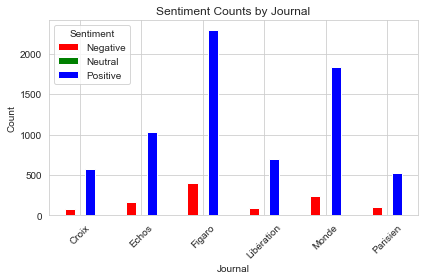

In [86]:
journal_sentiment_counts = df.groupby(['CJournal', 'sentiment']).size().unstack(fill_value=0)

# Counting sentiment occurrences for each crisis term
crisis_term_sentiment_counts = df.groupby(['crisis_term', 'sentiment']).size().unstack(fill_value=0)


# Define color palette
colors = ['red', 'green', 'blue']

# Plotting sentiment for each simplified Journal
journal_sentiment_counts.plot(kind='bar', color=colors)
plt.title('Sentiment Counts by Journal')
plt.xlabel('Journal')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


In [83]:
journal_sentiment_counts

sentiment,Negative,Neutral,Positive
CJournal,,,
Autre,94,1,625
Croix,83,0,574
Echos,65,0,408
Figaro,397,0,2298
Libération,92,0,691
Monde,236,1,1840
Parisien,96,0,525


Même si c'est très léger on voit que dans l'ensemble le sentiment est plutôt négatifs pour les journaux de droite que pour les journaux de gauche. Pour ce qui concerne le terme sélectionné pour scrapper les documents, le sentiment est plus négatif pour migrant/migratoire que pour refugee/asylum.

<Figure size 720x360 with 0 Axes>

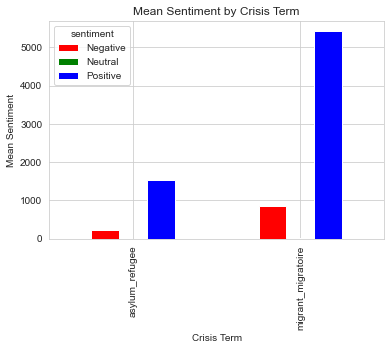

In [88]:
# Plotting sentiment for each crisis term
plt.figure(figsize=(10, 5))
# Define color palette
colors = ['red', 'green', "blue"]
crisis_term_sentiment_counts.plot(kind='bar', color=colors)
plt.title('Mean Sentiment by Crisis Term')
plt.xlabel('Crisis Term')
plt.ylabel('Mean Sentiment')
plt.show()

In [89]:
crisis_term_sentiment_counts

sentiment,Negative,Neutral,Positive
crisis_term,,,
asylum_refugee,214,0,1542
migrant_migratoire,849,2,5419


In [93]:
grouped_sentiment_counts

sentiment                      Negative  Neutral  Positive
CJournal   crisis_term                                    
Croix      asylum_refugee            15        0       132
           migrant_migratoire        68        0       442
Echos      asylum_refugee             0        0         2
           migrant_migratoire       159        1      1031
Figaro     asylum_refugee            87        0       507
           migrant_migratoire       310        0      1791
Libération asylum_refugee            22        0       209
           migrant_migratoire        70        0       482
Monde      asylum_refugee            76        0       611
           migrant_migratoire       160        1      1229
Parisien   asylum_refugee            14        0        81
           migrant_migratoire        82        0       444

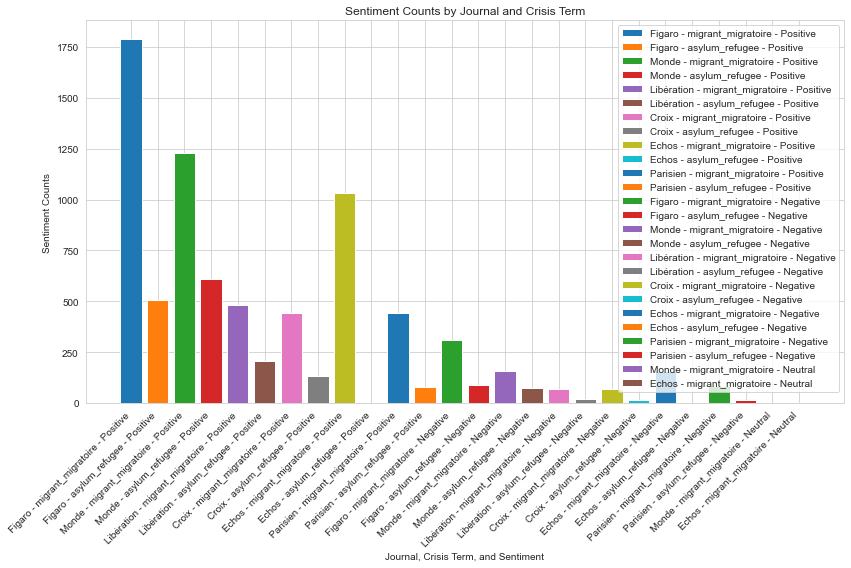

In [102]:
grouped_sentiment_counts = df.groupby(['CJournal', 'crisis_term', 'sentiment']).size().unstack(fill_value=0)

# Plotting sentiment for each Simplified Journal and crisis term
plt.figure(figsize=(12, 8))

# Iterate over each sentiment category
for sentiment in df['sentiment'].unique():
    # Subset the DataFrame for the specific sentiment
    df_sentiment = df[df['sentiment'] == sentiment]
    # Group by 'CJournal', 'crisis_term', and calculate sentiment counts
    grouped_sentiment_counts = df_sentiment.groupby(['CJournal', 'crisis_term']).size().unstack(fill_value=0)

    # Iterate over unique newspapers and crisis terms
    for journal in df['CJournal'].unique():
        for crisis_term in df['crisis_term'].unique():
            try:
                # Get sentiment count for the specific combination
                sentiment_count = grouped_sentiment_counts.loc[journal, crisis_term]
                # Plotting the sentiment count
                plt.bar(f"{journal} - {crisis_term} - {sentiment}", sentiment_count, label=f"{journal} - {crisis_term} - {sentiment}")
            except KeyError:
                pass

plt.title('Sentiment Counts by Journal and Crisis Term')
plt.xlabel('Journal, Crisis Term, and Sentiment')
plt.ylabel('Sentiment Counts')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


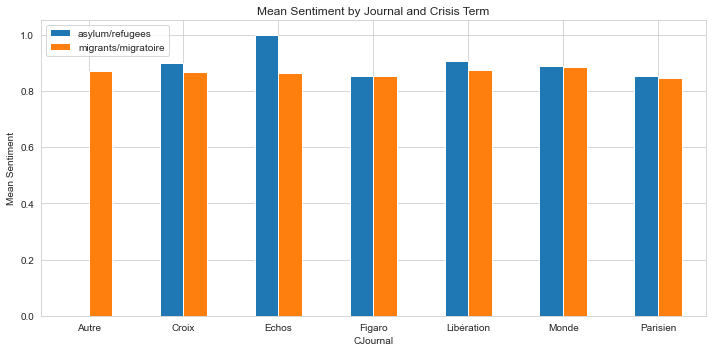

In [63]:
# Adding a 'Key' column to indicate the categories (here, 'Pauvres' and 'Autres')
df['Key'] = df['crisis_term'].apply(lambda x: 'migrants/migratoire' if x == 'migrant_migratoire' else 'asylum/refugees')

# Grouping by 'Simplified_Journal' and 'Key' and calculating mean sentiment
grouped_sentiment = df.groupby(['CJournal', 'Key'])['sentiment'].mean().unstack()

# Plotting sentiment for each Simplified Journal and Key
ax = grouped_sentiment.plot(kind='bar', ylabel='Mean Sentiment', title='Mean Sentiment by Journal and Crisis Term', figsize=(10, 5), rot=0)
plt.legend(['asylum/refugees', 'migrants/migratoire'], loc='upper left')
plt.tight_layout()
plt.show()

In [103]:
df['sentiment'] = df['sentiment'].replace('Positive',1)
df['sentiment'] = df['sentiment'].replace('Neutral',2)
df['sentiment'] = df['sentiment'].replace('Negative',0)

C:\Users\arceb\AppData\Local\Temp\ipykernel_2988\3213211793.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [104]:
df.drop( df[ df['sentiment'] == 2 ].index, inplace=True)

#### Subjectivity

The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [120]:
subjectivities = []

for text in df['motsFiltrer']:
    blob = tb(text)
    subjectivity = blob.subjectivity
    subjectivities.append(subjectivity)

# Add subjectivities to DataFrame
df['subjectivity'] = subjectivities

In [121]:
df

,Unnamed: 0,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,crisis_term,mots,motsFiltrer,sentiment,subjectivity
0,1,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle","LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les ...","Sur les camions militaires qui, en colonnes, ont relié Rome à Bergame la semaine dernière, les stick","Deux semaines pour se ressaisir et s'unir ou pour se résigner à la dislocation de l'Europe, qui ne se",Figaro,migrant_migratoire,"[LES, SYMBOLES, comptent, parfois, plus, que, les, faits, Sur, les, camions, militaires, qui, en, colonnes, ont, relié, Rome, à, Bergame, la, sema...",LES SYMBOLES comptent plus faits Sur camions militaires colonnes relié Rome Bergame semaine dernière stickers géants ornés drapeaux russe italien ...,1,0.450000
1,2,Le Monde,"Récit Les trois semaines qui ont chamboulé l'orthodoxie économique européenne Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...",2020-03-27,"àric Albert, Cécile Boutelet, Jérôme Gautheret et Virginie Malingre","Londres, Berlin, Rome et Bruxelles correspondants - Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en ...","- Jeudi 26 mars, les Vingt-Sept devaient se réunir en visioconférence pour la troisième fois en moin","pandémie touche tout le monde, indifféremment de la tenue de ses comptes publics, n'est pas si loin.",Monde,migrant_migratoire,"[Londres, Berlin, Rome, et, Bruxelles, correspondants, Jeudi, 26, mars, les, Vingt, Sept, devaient, se, réunir, en, visioconférence, pour, la, tro...",Londres Berlin Rome Bruxelles correspondants Jeudi 26 mars Vingt Sept devaient réunir visioconférence fois semaines Au programme discussions crise...,1,0.512963
2,3,Le Figaro (site web),àlargissement de l'Union européenne à l'heure du Coronavirus: «une fuite en avant suicidaire dans le déni»,2020-03-26,"Tandonnet, Maxime","Fin observateur de la vie politique française et contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompr...","contributeur régulier du FigaroVox, Maxime Tandonnet a notamment publié André Tardieu. L'incompris",es yeux et de se préparer au changement d'un monde plutôt que de s'enferrer dans des obsessions qui s,Figaro,migrant_migratoire,"[Fin, observateur, de, la, vie, politique, française, et, contributeur, régulier, du, FigaroVox, Maxime, Tandonnet, a, notamment, publié, André, T...",Fin observateur vie politique française contributeur régulier FigaroVox Maxime Tandonnet publié André Tardieu incompris Perrin 2019 Je heureux tat...,1,0.000000
3,4,Le Monde (site web),Coronavirus : les trois semaines qui ont chamboulé l'orthodoxie économique européenne,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet et Virginie Malingre","Jeudi 26 mars, les Vingt-Sept doivent se réunir en visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions...","n visioconférence pour la troisième fois en moins de trois semaines. Au programme des discussions, la","e la tenue de ses comptes publics, n'est pas si loin. Comme quoi, tous les tabous ne sont pas tombésâ¦",Monde,migrant_migratoire,"[Jeudi, 26, mars, les, Vingt, Sept, doivent, se, réunir, en, visioconférence, pour, la, troisième, fois, en, moins, de, trois, semaines, Au, progr...",Jeudi 26 mars Vingt Sept réunir visioconférence fois semaines Au programme discussions crise due coronavirus Europe entière exception Suède confin...,1,0.512963
4,5,Le Monde (site web),"Marc Lazar : « Plus l'Italie fait nation face à l'épidémie, plus elle s'éloigne de l'Union européenne »",2020-03-25,Marc Lazar,Tribune. L'Italie est le pays qui enregistre à la date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de 69 00...,date du 25 mars le plus grand nombre de morts dus au coronavirus â 6 820 â et plus de

In [122]:
selected_text = df[df['Unnamed: 0'] == 15]['Texte'].iloc[0]
print(selected_text)

Le président turc Recep Tayyip Erdogan a demandé à  l'Otan son « soutien concret » dans le conflit en Syrie, lors d'une visite à  Bruxelles lundi.   » LIRE AUSSI - Afflux explosif de migrants à  la frontière gréco-turque     « Nous attendons un soutien concret de la part de tous nos alliés », a lancé le dirigeant après une rencontre avec le secrétaire général de l'Otan Jens Stoltenberg. « L'Otan est dans un processus critique dans lequel elle doit clairement montrer sa solidarité d'alliance » avec la Turquie, a ajouté M. Erdogan.  Ankara souhaite que l'Otan applique pleinement ses décisions prises entre 2012 et 2015 de soutenir la défense aérienne turque, a-t-il expliqué. La visite de M. Erdogan dans la capitale de l'UE intervient après sa décision d'ouvrir les frontières turques au passage des migrants et des réfugiés qui se trouvent sur son territoire, pour forcer les pays européens à  « apporter leur soutien aux solutions politiques et humanitaires turques en Syrie ».   La Turquie a

In [123]:
selected_text = df[df['Unnamed: 0'] == 19]['Texte'].iloc[0]
print(selected_text)

Face aux conditions de vie précaires des migrants dans les à®les grecques, l'Allemagne prend la tête d'une coalition de pays européens «?volontaires?» à  l'accueil de mineurs.   Une coalition de pays « volontaires » de l'Union européenne envisage de prendre en charge jusqu'à  1 500 enfants migrants actuellement bloqués sur les à®les grecques, par mesure de soutien « humanitaire », a annoncé lundi 9 mars le gouvernement allemand.  ? REPORTAGE. é Paris, offrir un peu de répit aux jeunes migrants isolés   « Nous voulons aider la Grèce à  faire face à  la situation humanitaire difficile de 1 000 à  1 500 enfants se trouvant sur les à®les » du pays, ont ajouté les partis de la coalition gouvernementale de la chancelière Angela Merkel, conservateurs et sociaux-démocrates, à  l'issue d'une réunion de plusieurs heures qui avait commencé dimanche soir. « Il s'agit d'enfants qui, en raison d'une maladie ont urgemment besoin de soins, ou d'enfants non accompagnés et à¢gés de moins de 14 ans, pour

#### Learning

In [105]:
# Defining constants
epochs = 5
MAX_LEN = 128
batch_size = 1
device = torch.device('cuda')

In [106]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [107]:
# Creates list of texts and labels
text = df['Texte'].to_list()
labels = df['sentiment'].to_list()

#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,truncation=True,max_length=MAX_LEN) for sent in text]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [108]:
tokenizer.encode?

In [109]:
input_ids

array([[    5,  5311, 23196, ..., 23808,     9,     6],
       [    5,  3289,     7, ...,  6401,    14,     6],
       [    5,  4498,    21, ..., 27906,  6599,     6],
       ...,
       [    5,  6899,    25, ...,    56,    15,     6],
       [    5, 11366,  7043, ..., 21124,  6841,     6],
       [    5,   795,   193, ...,    16,   454,     6]])

In [110]:

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=42, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [111]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)
model.to(device)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
type(model)

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))




    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]

        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

print("Model saved!")
torch.save(model.state_dict(), "/content/drive/MyDrive/truspilot_category_data/sentiments_pytorch.pt")

### FLAUBERT

In [113]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

loaded_tokenizer = AutoTokenizer.from_pretrained('flaubert/flaubert_large_cased')
loaded_model = AutoModelForSequenceClassification.from_pretrained("DemangeJeremy/4-sentiments-with-flaubert")

nlp = pipeline('sentiment-analysis', model=loaded_model, tokenizer=loaded_tokenizer)

pytorch_model.bin:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

C:\Users\arceb\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\arceb\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development



In [115]:
# Creating an empty list to store the results
articles_sentiment = []

# Iterating over each row in the DataFrame
for index, row in df.iterrows():
    try:
        content = row['Titre']
        sentiment = nlp(content)
        articles_sentiment.append({'article': content, 'sentiment': sentiment})
    except Exception as e:
        print(f"Error processing article at index {index}: {e}")

KeyboardInterrupt: 

In [116]:
articles_sentiment

[{'article': "L'agenda caché de Moscou en Italie",
  'sentiment': [{'label': 'POSITIVE', 'score': 0.6883031129837036}]},
 {'article': "Récit   Les trois semaines qui ont chamboulé l'orthodoxie économique européenne  Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la réforme de la zone euro, dont la solidité est mise à\xa0 mal par la pandémie",
  'sentiment': [{'label': 'MIXED', 'score': 0.4768875241279602}]},
 {'article': "à\x89largissement de l'Union européenne à\xa0 l'heure du Coronavirus: «une fuite en avant suicidaire dans le déni»",
  'sentiment': [{'label': 'MIXED', 'score': 0.40838807821273804}]},
 {'article': "Coronavirus\xa0: les trois semaines qui ont chamboulé l'orthodoxie économique européenne",
  'sentiment': [{'label': 'OBJECTIVE', 'score': 0.4552094638347626}]},
 {'article': "Marc Lazar\xa0: «\xa0Plus l'Italie fait nation face à\xa0 l'épidémie, plus elle s'éloigne de l'Union européenne\xa0»",
  'sentiment': [{'label': 'OBJECTIVE', 'score': 0.5507673621177673